In [2]:
from keras.models import load_model

In [3]:
model = load_model('cats_and_dogs_small_2.h5')
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 74, 74, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_13 (Conv2D)          (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_13 (MaxPoolin  (None, 36, 36, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_14 (Conv2D)          (None, 34, 34, 128)       73856     
                                                                 
 max_pooling2d_14 (MaxPoolin  (None, 17, 17, 128)     

In [4]:
img_path = "cats_and_dogs_small/test/cats/cat.1700.jpg"

In [5]:
from keras.preprocessing import image
import numpy as np

In [6]:
img = image.image_utils.load_img(img_path, target_size=(150, 150))
img_tensor = image.image_utils.img_to_array(img)
img_tensor = np.expand_dims(img_tensor, axis=0)
img_tensor /= 255.

In [7]:
print(img_tensor.shape)

(1, 150, 150, 3)


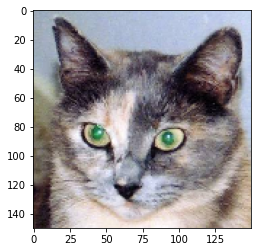

In [8]:
import matplotlib.pyplot as plt

plt.imshow(img_tensor[0])
plt.show()

In [9]:
from keras import models

In [10]:
layer_outputs = [layer.output for layer in model.layers[:8]]

In [11]:
activation_model = models.Model(inputs = model.input, outputs = layer_outputs)

In [12]:
activations = activation_model.predict(img_tensor)

1/1 [==============================] - 2s 2s/step


In [13]:
first_layer_activation = activations[0]
print(first_layer_activation.shape)

(1, 148, 148, 32)


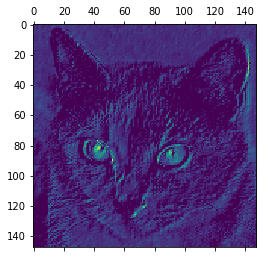

In [14]:
plt.matshow(first_layer_activation[0,:,:,4], cmap = "viridis")

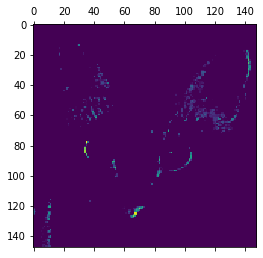

In [15]:
plt.matshow(first_layer_activation[0,:,:,7], cmap = "viridis")

In [16]:
layer_names = []
for layer in model.layers[:8]:
    layer_names.append(layer.name)

In [17]:
images_per_row = 16

C:\Users\jnrah\AppData\Local\Temp\ipykernel_5044\339440127.py:10: RuntimeWarning: invalid value encountered in divide
  channel_image /= channel_image.std()


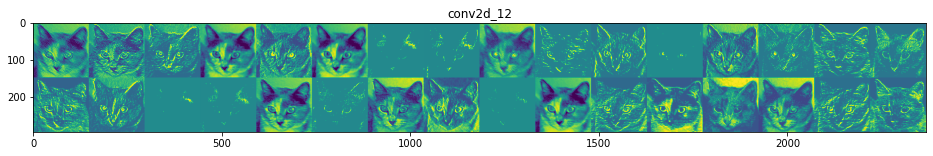

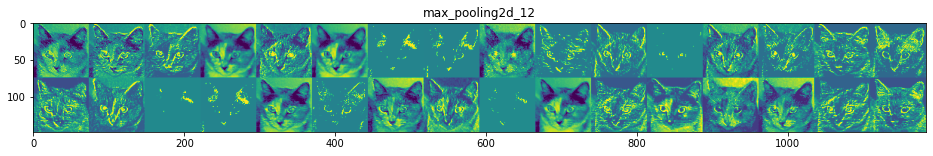

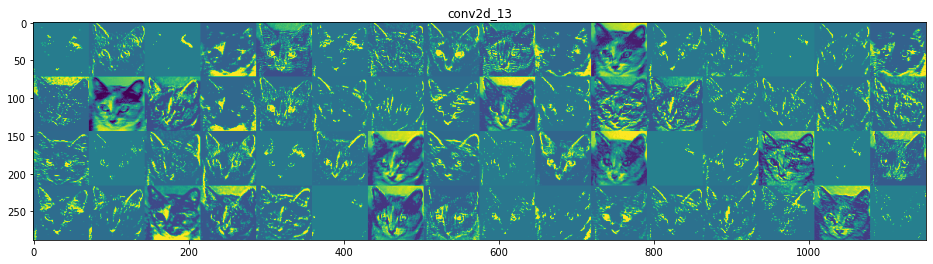

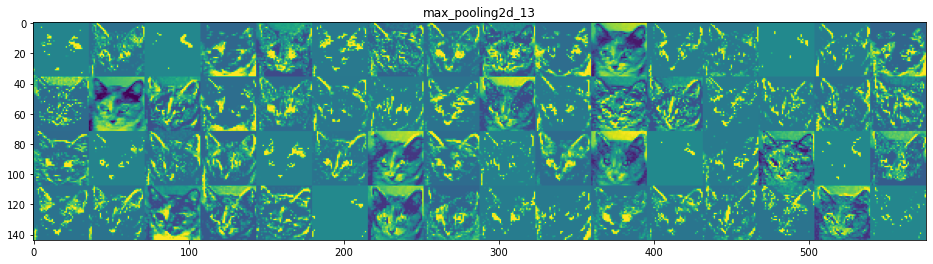

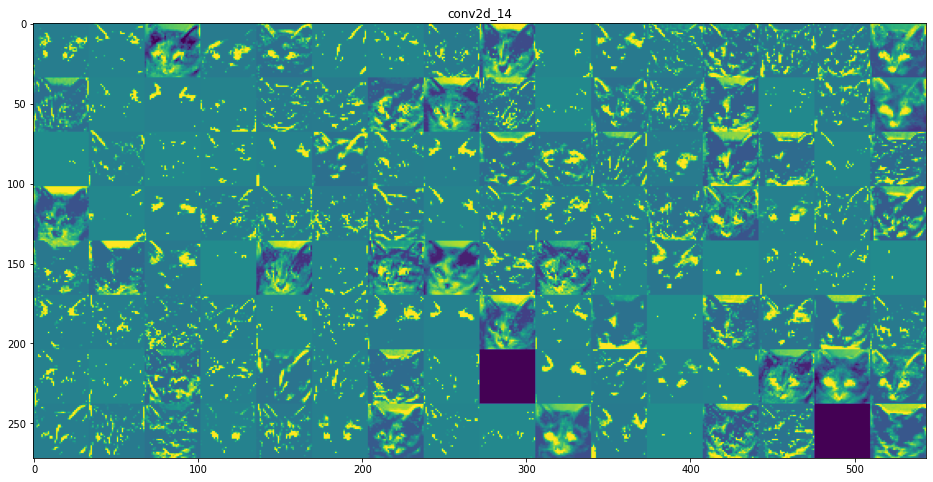

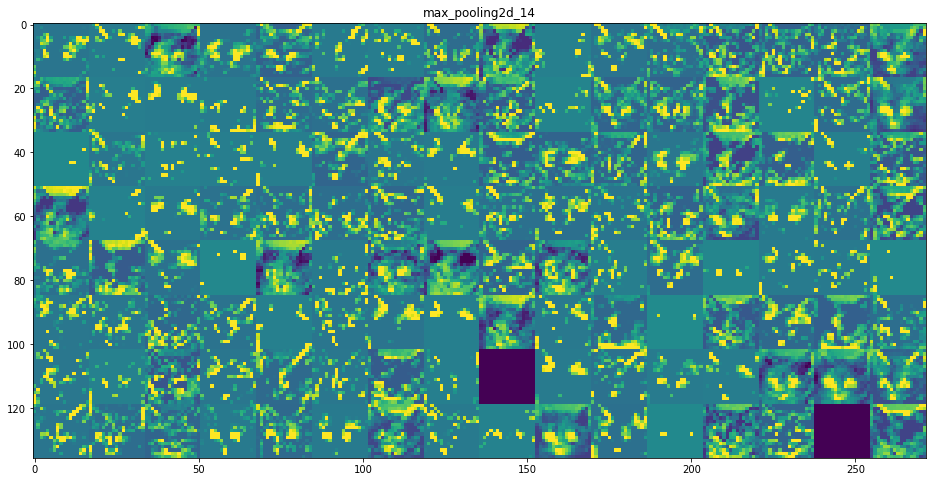

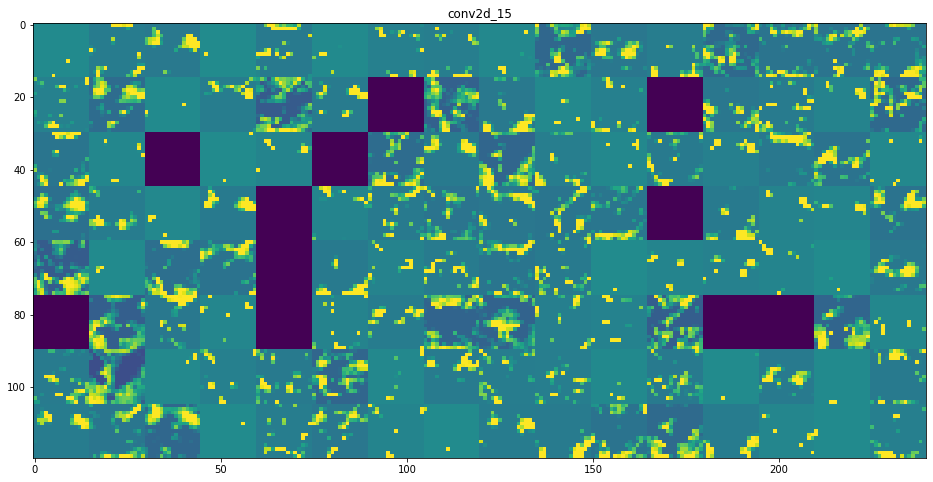

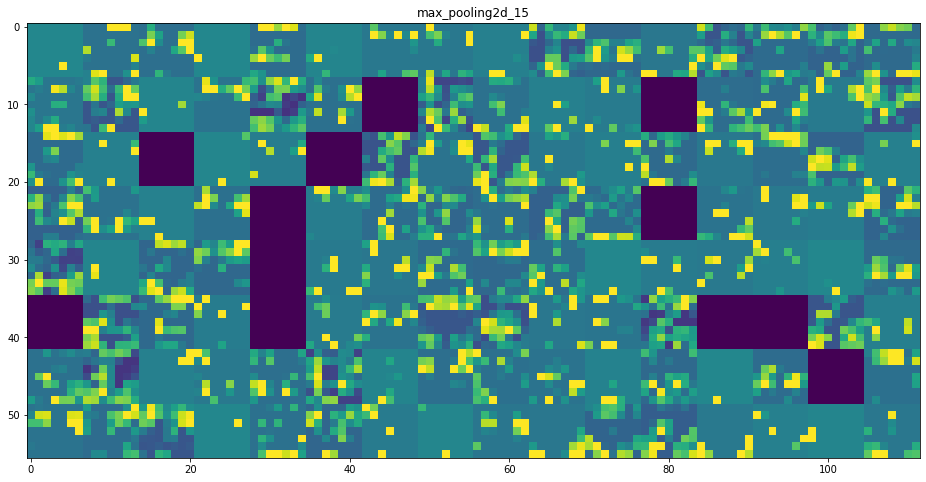

In [19]:
for layer_name, layer_activation in zip(layer_names, activations):
    n_features = layer_activation.shape[-1]
    size = layer_activation.shape[1]
    n_cols = n_features // images_per_row
    display_grid = np.zeros((size * n_cols, images_per_row*size))
    for col in range(n_cols):
        for row in range(images_per_row):
            channel_image = layer_activation[0,:,:,col*images_per_row+row]
            channel_image -= channel_image.mean()
            channel_image /= channel_image.std()
            channel_image *= 64
            channel_image += 128
            channel_image = np.clip(channel_image, 0, 255).astype('uint8')
            display_grid[col*size : (col + 1)*size, row*size:(row+1)*size] = channel_image
    scale = 1./size
    plt.figure(figsize=(scale*display_grid.shape[1],
                       scale*display_grid.shape[0]))
    plt.title(layer_name)
    plt.grid(False)
    plt.imshow(display_grid, aspect='auto', cmap="viridis")

In [21]:
from keras.applications import VGG16
from keras import backend as K

In [30]:
model = VGG16(weights="imagenet", include_top = False)

In [31]:
layer_name = "block3_conv1"

In [32]:
filter_index = 0

In [33]:
layer_output = model.get_layer(layer_name).output

In [34]:
loss = K.mean(layer_output[:,:,:, filter_index])

In [28]:
import tensorflow as tf
tf.compat.v1.disable_eager_execution()

In [35]:
grads = K.gradients(loss, model.input)[0]

In [36]:
grads /= (K.sqrt(K.mean(K.square(grads)))+1e-5)

In [37]:
iterate = K.function([model.input],[loss, grads])

In [38]:
loss_value, grads_value = iterate([np.zeros((1,150,150,3))])

In [39]:
input_img_data = np.random.random((1,150,150,3))*20+128

In [40]:
step = 1

In [41]:
for i in range(40):
    loss_value, grads_value = iterate([input_img_data])
    input_img_data += grads_value * step

In [45]:
def deprocess_image(x):
    x -= x.mean()
    x /= (x.std() + 1e-5)
    x *= 0.1
    x += 0.5
    c = np.clip(x, 0, 1)
    x *= 255
    x = np.clip(x, 0, 255).astype('uint8')
    return x

In [46]:
def generate_pattern(layer_name, filter_index, size = 150):
    layer_output = model.get_layer(layer_name).output
    loss = K.mean(layer_output[:,:,:,filter_index])
    grads = K.gradients(loss, model.input)[0]
    grads /= (K.sqrt(K.mean(K.square(grads)))+1e-5)
    iterate = K.function([model.input],[loss, grads])
    input_img_data = np.random.random((1,size,size,3))*20 + 128.
    step = 1
    for i in range(40):
        loss_value, grads_value = iterate([input_img_data])
        input_img_data += grads_value * step
    img = input_img_data[0]
    return deprocess_image(img)

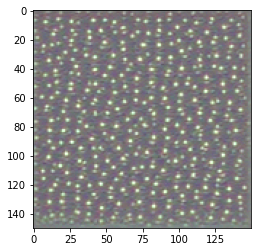

In [47]:
plt.imshow(generate_pattern('block3_conv1',0))

In [51]:
layer_name = "block1_conv1"
size = 64
margin = 5

In [52]:
results = np.zeros((8*size + 7*margin, 8*size+7*margin,3))

In [53]:
for i in range(8):
    for j in range(8):
        filter_img = generate_pattern(layer_name, i+(j*8),size=size)
        horizontal_start = i*size + i*margin
        horizontal_end = horizontal_start+size
        vertical_start = j*size + j*margin
        vertical_end = vertical_start+size
        results[horizontal_start:horizontal_end,vertical_start:vertical_end,:] = filter_img

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


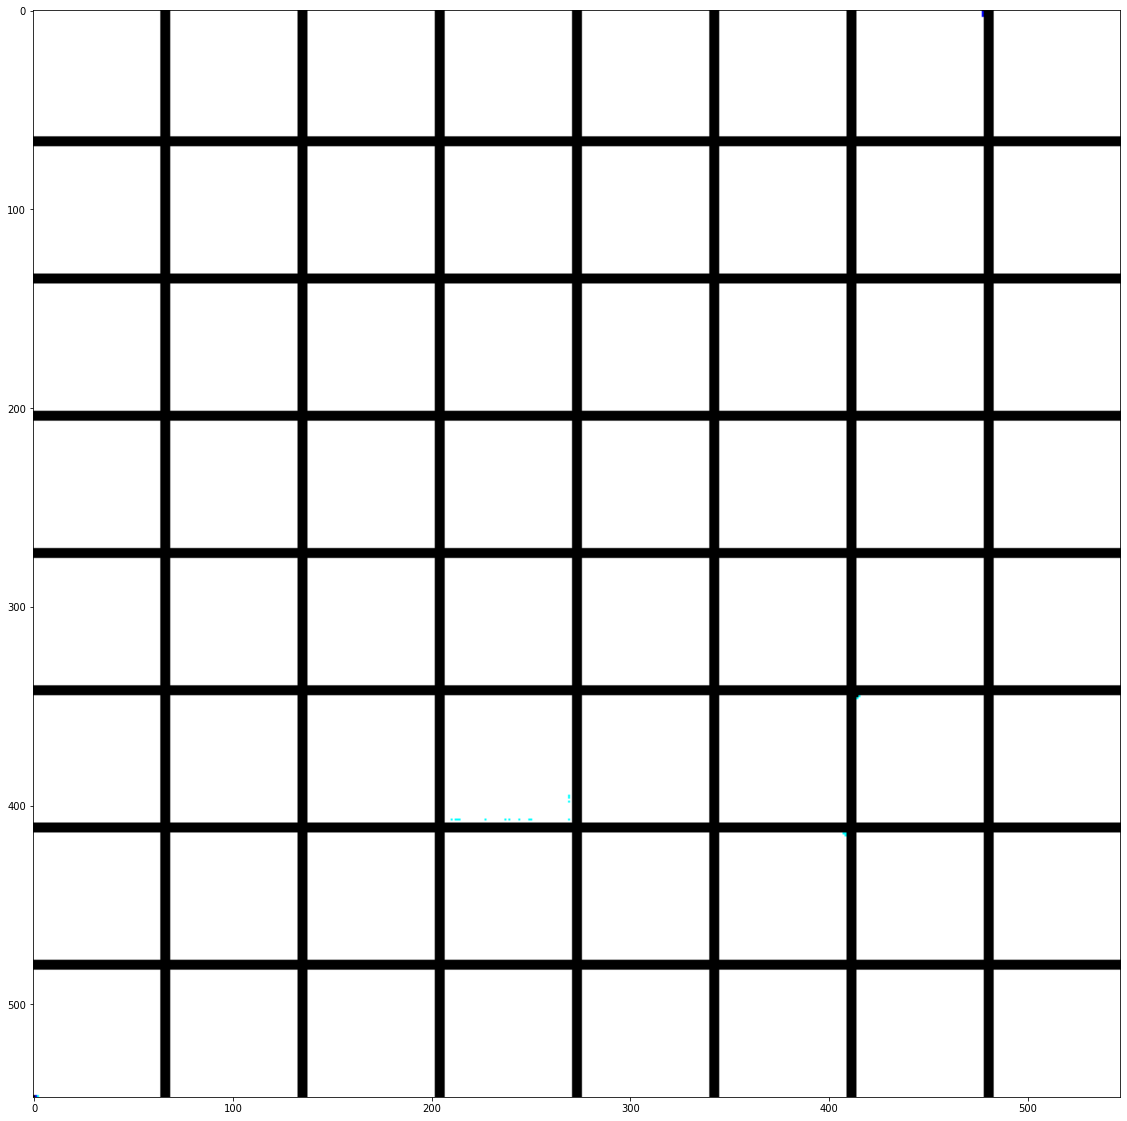

In [56]:
plt.figure(figsize=(20,20))
plt.imshow(results)

In [60]:
model = VGG16(weights='imagenet')

553467096/553467096 [==============================] - 51s 0us/step


In [61]:
from keras.applications.vgg16 import preprocess_input, decode_predictions

In [62]:
img_path = "C:/Users/jnrah/Downloads/elephant.jpg"

In [63]:
img = image.image_utils.load_img(img_path, target_size=(224,224))

In [64]:
x = image.image_utils.img_to_array(img)

In [65]:
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)

In [66]:
preds = model.predict(x)

D:\anaconda3\envs\Keras_DL_Book\lib\site-packages\keras\engine\training_v1.py:2067: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


In [67]:
print("Predcited : ", decode_predictions(preds, top=3)[0])

35363/35363 [==============================] - 0s 1us/step
Predcited :  [('n02504458', 'African_elephant', 0.7518269), ('n01871265', 'tusker', 0.20853123), ('n02504013', 'Indian_elephant', 0.030940292)]


In [68]:
np.argmax(preds[0])

386

In [71]:
african_elphant_output = model.output[:,386]

In [72]:
last_conv_layer = model.get_layer("block5_conv3")

In [73]:
grads = K.gradients(african_elphant_output, last_conv_layer.output)[0]

In [74]:
pooled_grads = K.mean(grads, axis=(0,1,2))

In [75]:
iterate = K.function([model.input],[pooled_grads, last_conv_layer.output[0]])

In [76]:
pooled_grads_value, conv_layer_output_value = iterate([x])

In [77]:
for i in range(512):
    conv_layer_output_value[:,:,i] *= pooled_grads_value[i]

In [78]:
heatmap = np.mean(conv_layer_output_value, axis=-1)

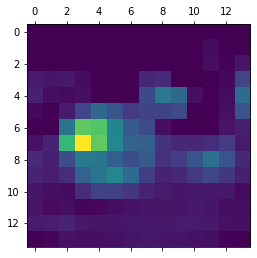

In [79]:
heatmap = np.maximum(heatmap,0)
heatmap /= np.max(heatmap)
plt.matshow(heatmap)